In [1]:
import csv
import os
import random

In [2]:
train_size = 0.8  # training set proportion
val_size = 0.1  # validation set proportion

# set how many videos to incorporate in dataset from each class
max_class_size = 300 # something arbitrarily large will generate .npy for all data

random.seed(1)  # generate same random dataset

In [3]:
# --- EXECUTE THIS CELL TO CREATE DATASET CSV FILE --- #

with open('E:/opencv/git/data_file.csv', 'w',newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    # get subdirectories in VIDEO_RGB

    path = os.path.join('E:/opencv/thetis/VIDEO_RGB')

    # ignore .DS_store
    class_folders = [item for item in os.listdir(path) if not item.startswith('.')]
    
    
    # iterate over each folder, and write train/test samples to csv file
    for class_label in class_folders:
#         print class_label

        subpath = os.path.join(path, class_label)

        videos = []
        for vid in os.listdir(subpath):
            
            # make sure vid is a file and not .DS_Store
            if os.path.isfile(os.path.join(subpath, vid)) and not vid.startswith('.'):
                vid = os.path.splitext(vid)[0]
                videos.append(vid)

        # --- EDIT THESE LINES: choose what sequences to generate ---- #
        
        # TURN ON RANDOM SHUFFLE WHEN GENERATING ACTUAL DATASET
        random.shuffle(videos)  # NOTE: shuffles videos in place

        # alter size of dataset
        if max_class_size < len(videos):
            videos = videos[:max_class_size]
            
        # ------------------------------------------------------------ #

        # split into training and test sets
        train_split_ind = int(round(train_size*len(videos)))
        val_split_ind = train_split_ind + int(round(val_size*len(videos)))
        
        train = videos[0:train_split_ind]
        validation = videos[train_split_ind:val_split_ind]
        test = videos[val_split_ind:]

        # --- RELABEL TO CONSOLIDATE CLASSES --- #
        if class_label == 'backhand2h' or class_label == 'bslice':
            class_label = 'backhand'
            
        if class_label == 'foreflat' or class_label == 'foreopen' or class_label == 'fslice':
            class_label = 'forehand'
            
        if class_label == 'serflat' or class_label == 'serkick' or class_label == 'serslice':
            class_label = 'service'

        # write train_size proportion to csv as train
        for sample in train:
            writer.writerow(['train'] + [class_label] + [sample])
            
        # write val_size proportion to csv as validation
        for sample in validation:
            writer.writerow(['validation'] + [class_label] + [sample])
        
        # write remaining proportion to csv as test
        for sample in test:
            writer.writerow(['test'] + [class_label] + [sample])

In [4]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense
from data_utils import DataSet
import data_utils
import numpy as np
import os.path
import time

In [5]:
def load_cnn_model():
    base_model = InceptionV3(weights=r'E:\opencv\git\inception_v3_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)
    
    #print(base_model.summary())
    #print base_model.get_layer('global_max_pooling2d_1').output
    outputs = base_model.get_layer('avg_pool').output

    cnn_model = Model(inputs=base_model.input, outputs=outputs)

    return cnn_model

In [6]:
cnn_model = load_cnn_model()

In [7]:
seq_length = 16
dataset = DataSet(cnn_model)

In [8]:
dataset.data[0]

['train', 'backhand', 'p22_backhand_s2']

In [10]:
tic = time.time()

for ind, sample in enumerate(dataset.data):
    
    path = os.path.join('E:/opencv/git', 'sequences', sample[1], sample[2] + '-' + str(seq_length) + \
        '-features')
    
    if os.path.isfile(path):
        print("Sequence: {} already exists".format(ind))
    else:
        print("Generating and saving sequence: {}".format(ind))
        sequence = dataset.extract_seq_features(sample)

print("Time Elapsed: {}".format(time.time() - tic))

Generating and saving sequence: 0
Generating and saving sequence: 1
Generating and saving sequence: 2
Generating and saving sequence: 3
Generating and saving sequence: 4
Generating and saving sequence: 5
Generating and saving sequence: 6
Generating and saving sequence: 7
Generating and saving sequence: 8
Generating and saving sequence: 9
Generating and saving sequence: 10
Generating and saving sequence: 11
Generating and saving sequence: 12
Generating and saving sequence: 13
Generating and saving sequence: 14
Generating and saving sequence: 15
Generating and saving sequence: 16
Generating and saving sequence: 17
Generating and saving sequence: 18
Generating and saving sequence: 19
Generating and saving sequence: 20
Generating and saving sequence: 21
Generating and saving sequence: 22
Generating and saving sequence: 23
Generating and saving sequence: 24
Generating and saving sequence: 25
Generating and saving sequence: 26
Generating and saving sequence: 27
Generating and saving sequence

In [1]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Lambda, Dropout
from keras import backend as K
from keras import regularizers
from data_utils import DataSet

import numpy as np
import os
import os.path
import time

from utils import Params
from utils import set_logger
import argparse
import logging

# import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--model_dir', default='experiments/base_model',help="Directory containing params.json")

_StoreAction(option_strings=['--model_dir'], dest='model_dir', nargs=None, const=None, default='experiments/base_model', type=None, choices=None, help='Directory containing params.json', metavar=None)

In [3]:
def lstm(num_features=2048, hidden_units=256, dense_units=256, reg=1e-1, dropout_rate=1e-1, seq_length=16, num_classes=12):

    # hidden_units: dimension of cell
    # dense_units: number of neurons in fully connected layer above LSTM
    # reg: regularization for LSTM and dense layer
    # - currently adding L2 regularization for RNN connections, and for inputs to dense layer

    model = Sequential()

    # return_sequences flag sets whether hidden state returned for each time step
    # NOTE: set return_sequences=True if using TimeDistributed, else False


    # LSTM layer (dropout)
    model.add(Dropout(dropout_rate, input_shape=(seq_length, num_features)))  # input to LSTM
    model.add(LSTM(hidden_units, return_sequences=True))
    
    # --- AVERAGE LSTM OUTPUTS --- #

    # dropout between LSTM and softmax
    model.add(TimeDistributed(Dropout(dropout_rate)))

    # commenting out additional FC layer for now
    # model.add(TimeDistributed(Dense(dense_units)))
    
    # apply softmax
    model.add(TimeDistributed(Dense(num_classes, activation="softmax")))
    
    # average outputs
    average_layer = Lambda(function=lambda x: K.mean(x, axis=1))
    model.add(average_layer)
    
    # --- ONLY TAKE LAST LSTM OUTPUT --- #
    # model.add(Dense(dense_units))
    # model.add(Dense(num_classes, activation="softmax"))
    
    return model

In [4]:
def train(model_dir, cnn_model, saved_model=None, 
            learning_rate = 1e-5, decay=1e-6, 
            train_size = 0.8, seq_length=16,
            hidden_units=256, dense_units=256, reg=1e-1, dropout_rate=1e-1,
            num_classes=12, batch_size=16, nb_epoch=100, 
            image_shape=None):


    # ---- CALL BACK FUNCTIONS FOR FIT_GENERATOR() ---- #
    checkpoints_dir = os.path.join(model_dir, 'checkpoints')
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    checkpointer = ModelCheckpoint(
            filepath=os.path.join(checkpoints_dir, 'lstm_weights.{epoch:004d}-{val_loss:.3f}.hdf5'),
            verbose=1, save_best_only=False, period=50)

    # tensorboard info
    tb = TensorBoard(log_dir=model_dir)

# ------------------------------------------------- # 


    # PREPARE DATASET
    dataset = DataSet(cnn_model, seq_length)
    
    # steps_per_epoch = number of batches in one epoch
    steps_per_epoch = (len(dataset.data) * train_size) // batch_size

    # create train and validation generators
    generator = dataset.frame_generator(batch_size, 'train')
    # val_generator = dataset.frame_generator(batch_size, 'validation') # use all validation data each time?
    (X_val, y_val) = dataset.generate_data('validation')

    # load or create model
    if saved_model:
        rnn_model = load_model(saved_model)
    else:
        rnn_model = lstm(hidden_units=hidden_units, dense_units=dense_units, 
                        reg=reg, dropout_rate=dropout_rate,
                        seq_length=seq_length, num_classes=num_classes)

    # setup optimizer: ADAM algorithm
    optimizer = Adam(lr=learning_rate, decay=decay)
    
    # metrics for judging performance of model
    metrics = ['categorical_accuracy'] # ['accuracy']  # if using 'top_k_categorical_accuracy', must specify k
    
    rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer,
            metrics=metrics)

    print(rnn_model.summary())

    # use fit generator to generate data on the fly
    history = rnn_model.fit_generator(generator=generator,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=nb_epoch,
                                    verbose=1,
                                    callbacks=[tb, checkpointer],
                                    validation_data=(X_val, y_val),
                                    validation_steps=1)  # using all validation data for better metrics

    return history

In [5]:
if __name__ == '__main__':

    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    json_path = os.path.join(args.model_dir, 'params.json')
    assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
    params = Params(json_path)

    # ----- DUMMY MODEL TO PASS IN AS CNN_MODEL ---- #
    #       (feature extraction not performed in this script)

    a = Input(shape=(1,))
    b = Dense(1)(a)
    model = Model(inputs=a, outputs=b)

    cnn_model = Model(inputs=a, outputs=b)


    # ---- LOAD PARAMETERS FOR TRAINING ---- #

    if params.saved_model == "None":
        saved_model = None
    else:
        saved_model = params.saved_model

    # --- hyperparameters --- #
    learning_rate = params.learning_rate
    decay = params.decay

    hidden_units = params.hidden_units
    dense_units = params.dense_units

    reg = params.reg
    dropout_rate = params.dropout_rate

    batch_size = params.batch_size
    nb_epoch = params.nb_epoch

    # --- other parameters --- #
    train_size = params.train_size
    num_classes = params.num_classes
    seq_length = params.seq_length

    # --- EXECUTE TRAINING --- #
    history = train(args.model_dir, cnn_model, saved_model=saved_model, 
                        learning_rate = learning_rate, decay = decay, 
                        train_size = train_size, seq_length = seq_length,
                        hidden_units = hidden_units, dense_units = dense_units, reg=reg,
                        num_classes = num_classes,
                        batch_size = batch_size, nb_epoch = nb_epoch)


    print("\nCompleted training! \n")

    # --- SAVE HISTORY AS PICKLE FILE --- #
    save_path = os.path.join(args.model_dir, 'train_history.pkl')

    with open(save_path, 'wb') as save_file:
        pickle.dump(history.history, save_file, protocol=2)  # make sure python 2.7 can read

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 16, 2048)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16, 128)           1114624   
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 12)            1548      
_________________________________________________________________
lambda (Lambda)              (None, 12)                0         
Total params: 1,116,172
Trainable params: 1,116,172
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use Model.fit, which supports generators.
Creating train generator with 1

In [8]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Lambda, Dropout
from keras import backend as K
from keras import regularizers
from data_utils import DataSet

import numpy as np
import os
import os.path
import time

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
def lstm(num_features=2048, hidden_units=256, dense_units=256, reg=1e-1, dropout_rate=1e-1, seq_length=16, num_classes=12):

    # hidden_units: dimension of cell
    # dense_units: number of neurons in fully connected layer above LSTM
    # reg: regularization for LSTM and dense layer
    # - currently adding L2 regularization for RNN connections, and for inputs to dense layer

    model = Sequential()

    # return_sequences flag sets whether hidden state returned for each time step
    # NOTE: set return_sequences=True if using TimeDistributed, else False

    # LSTM layer (L2)
    #     model.add(LSTM(hidden_units, input_shape=(seq_length, num_features), 
    #                    return_sequences=True,
    #                    kernel_regularizer=regularizers.l2(reg),
    #                    recurrent_regularizer=regularizers.l2(reg)))

    # LSTM layer (dropout)
    model.add(Dropout(dropout_rate, input_shape=(seq_length, num_features)))  # input to LSTM
    model.add(LSTM(hidden_units, return_sequences=True))

    # --- AVERAGE LSTM OUTPUTS --- #

    # linear activation layer (L2 regularization)
    #     model.add(TimeDistributed(Dense(dense_units, 
    #                                     kernel_regularizer=regularizers.l2(reg))))

    # dropout between LSTM and softmax
    model.add(TimeDistributed(Dropout(dropout_rate)))

    # commenting out additional FC layer for now
    # model.add(TimeDistributed(Dense(dense_units)))

    # apply softmax
    model.add(TimeDistributed(Dense(num_classes, activation="softmax")))

    # average outputs
    average_layer = Lambda(function=lambda x: K.mean(x, axis=1))
    model.add(average_layer)

    # --- ONLY TAKE LAST LSTM OUTPUT --- #
    # model.add(Dense(dense_units, kernel_regularizer=regularizers.l2(reg)))
    # model.add(Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(reg)))

    return model

50/50 [==============================] - 1s 23ms/step - loss: 0.4296 - categorical_accuracy: 0.9337
Train Loss: 0.430
Train Accuracy: 0.934

6/6 [==============================] - 0s 22ms/step - loss: 1.1198 - categorical_accuracy: 0.5781
Val Loss: 1.120
Val Accuracy: 0.578

7/7 [==============================] - 0s 16ms/step - loss: 1.1330 - categorical_accuracy: 0.6176
Test Loss: 1.133
Test Accuracy: 0.618

                     precision    recall  f1-score   support

           backhand       0.69      0.53      0.60        17
     backhand_slice       0.90      0.53      0.67        17
    backhand_volley       0.62      0.47      0.53        17
     backhand2hands       0.67      0.71      0.69        17
       flat_service       0.40      0.35      0.38        17
      forehand_flat       0.67      0.94      0.78        17
forehand_openstands       0.68      0.76      0.72        17
     forehand_slice       0.45      0.53      0.49        17
    forehand_volley       0.83      0

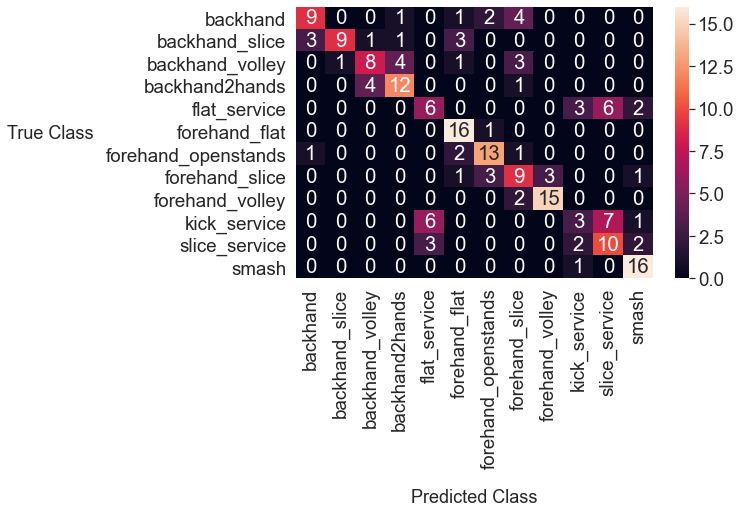

In [19]:
if __name__ == "__main__":

    # ------ REPLICATE PARAMETERS USED IN EXPERIMENT ------ #

    # ---- HYPER-PARAMETERS TO BE SET ---- #

    learning_rate= 1e-3 # 1e-4
    decay=0.0

    hidden_units = 128
    dense_units = 128
    reg = 0.0           # L2 regularization
    dropout_rate = 0.3  # dropout regularization
    batch_size = 128
    nb_epoch = 300 # 100


    # ---- OTHER PARAMETERS ---- #
    train_size = 0.8  # proportion of dataset that is training
    saved_model = None  # None, or pass in weights file
    # saved_model = "data/checkpoints/lstm_weights.0026-0.239.hdf5"

    num_classes = 12
    seq_length = 16    # essentially number of frames


    # --- LOAD DUMMY CNN MODEL --- #
    a = Input(shape=(1,))
    b = Dense(1)(a)
    model = Model(inputs=a, outputs=b)

    cnn_model = Model(inputs=a, outputs=b)


    # ------ EVALUATE MODEL ------ #
    # have to reinstantiate model to load weights properly (python3 --> python2.7 problem)
    rnn_model = lstm(hidden_units=hidden_units, dense_units=dense_units, 
                    reg=reg, dropout_rate=dropout_rate,
                    seq_length=seq_length, num_classes=num_classes)

    # setup optimizer: ADAM algorithm
    optimizer = Adam(lr=learning_rate, decay=decay)

    # metrics for judging performance of model
    metrics = ['categorical_accuracy'] # ['accuracy']  # if using 'top_k_categorical_accuracy', must specify k

    rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer,
        metrics=metrics)


    # load saved weights
    # folder_path = 'experiments/base_model/base_model_dropout_rate_0.00e+00/checkpoints/'
    folder_path = 'experiments/base_model/base_model_dropout_rate_3.00e-01/checkpoints/'

    saved_weights = os.path.join(folder_path, 'lstm_weights.0300-1.120.hdf5')
    rnn_model.load_weights(saved_weights)

    # load and prepare test set
    dataset = DataSet(cnn_model)

    X_train, Y_train = dataset.generate_data('train')
    X_val, Y_val = dataset.generate_data('validation')
    X_test, Y_test = dataset.generate_data('test')

    score = rnn_model.evaluate(x=X_train, y=Y_train, verbose=1)
    print("Train Loss: %2.3f" % score[0])
    print("Train Accuracy: %1.3f\n" % score[1])

    score = rnn_model.evaluate(x=X_val, y=Y_val, verbose=1)
    print("Val Loss: %2.3f" % score[0])
    print("Val Accuracy: %1.3f\n" % score[1])

    score = rnn_model.evaluate(x=X_test, y=Y_test, verbose=1)
    print("Test Loss: %2.3f" % score[0])
    print("Test Accuracy: %1.3f\n" % score[1])


    # --- MISCLASSIFICATION ANALYSIS --- #
    Y_pred_class = rnn_model.predict_classes(X_test)
    Y_test_class = np.argmax(Y_test, axis=1)


    target_names = ['backhand', 'backhand_slice','backhand_volley','backhand2hands','flat_service', 'forehand_flat','forehand_openstands','forehand_slice', 'forehand_volley', 
                   'kick_service','slice_service', 'smash']
    print (classification_report(Y_test_class, Y_pred_class, target_names=target_names))
    conf_matrix = confusion_matrix(Y_test_class, Y_pred_class)

    sns.set(font_scale=1.7)
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                      columns = [i for i in target_names])
    plt.figure(figsize = (8,5))
    ax = sns.heatmap(df_cm, annot=True)
    ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
    ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
    plt.show()